## My Spotify Wrapped Trends, since 2018

This is a notebook that performs some basic data processing operations on my own Spotify Wrapped playlists from 2018 (when I started using Spotify). 

*Note on Fetching Playlist Data:*

Fetching the data from Spotify's API is done using the `spotify` Python Library. Being an asynchronous implementation of the API, it didn't play too nice with Jupyter in my experience, so it has been separately implemented in `playlists.py`. By default, running the script returns `list.csv`, which is used as the data source in this notebook.


### Initialisation

Loading libraries and data.

In [33]:
# importing libraries

import pandas as pd
import numpy as np
import hashlib
import textwrap
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

In [34]:
# accessing csv (created by playlists.py script)

file = "list.csv"
df = pd.read_csv(file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     700 non-null    int64 
 1   index    700 non-null    int64 
 2   name     700 non-null    object
 3   artists  700 non-null    object
 4   id       700 non-null    object
 5   link     700 non-null    object
dtypes: int64(2), object(4)
memory usage: 32.9+ KB


### Data Processing

#### Creating 'song_id' column:

The CSV is all populated with datapoints directly fetched from the API. We must do some cleaning and other processing for our purposes.

1. Creating a 'combined' column, and then dropping it: There are some tracks in these playlists that are the exact same songs and performances, but have different Spotify IDs<sup>[1]</sup>. So we needed an id of our own, created by the concatenation of the song name and artist names. By making this field all lowercase, we also avoid another edge case<sup>[2]</sup> Not the most precise implementation<sup>[3]</sup>, but it works for our use case. 

2. The 'combined' column is then hashed to create 'song_id'. There is not much reason to hash the data; there can be any alternative method to make up an identifier of this data, but hashing in this case is more straightforward to create unique values from the 'combined' field (see [2])


<sup><sub>[1] Possibly being Single releases vs. Album tracks, etc.</sub></sup>

<sup><sub>[2] Some tracks can have some words capitalised or not ("the" vs. "The"), despite being the same tracks.</sub></sup>

<sup><sub>[3] Re-released music with changed song names (yes, this is the "(Taylor's Version)" edge case) would require you to match the titles in the DataFrame</sub></sup>

In [35]:
# Combine "name" and "artists" columns into a new column "combined"
df['combined'] = (df['name'] + ' - ' + df['artists']).str.lower() # addressing the "the"/"The" issue

# Hash the combined values to create a unique song_id - some songs have different spotify IDs but are the exact same track
df['song_id'] = df['combined'].apply(lambda x: hashlib.md5(x.encode()).hexdigest())

df = df.drop(columns=['combined'])
# TODO: might need some further wrangling for tv tracks later - keeping older tracks as it is

#### Pivoting the DataFrame:

This is where song_id comes in handy. Songs appearing in more than one Wrapped lists have the same ID, so by pivoting over song_id as our index, for all the 'year' columns, we get a more manuverable table which we can use for all further processing. This creates a table with only song_id's and the yearly ranks. Songs that don't appear in some year's list get the value ``0`` for that year.

We add the song name (``name``) and artist name (``artists``) back in the next step, to bring together all distinct songs, despite them having different Spotify IDs.

In [36]:
# pivoting table, for years on song_id

years = df['year'].unique().tolist() # final value, used quite often in the data analysis section

pivot_df = df.pivot_table(index='song_id', columns='year', values='index', fill_value=0)

# Reset the index to make 'song_id' a regular column
pivot_df = pivot_df.reset_index()

# convert floats to int to make data cleaner
pivot_df[years] = pivot_df[years].astype(int)


In [37]:
# adding back song names and artists on song_id values

if df['song_id'].duplicated().any():
    df = df.drop_duplicates(subset='song_id')
    
pivot_df = pd.merge(pivot_df, df[['name', 'artists', 'song_id']], on='song_id', how='left')
pivot_df # working dataset - data cleaned

,song_id,2018,2019,2020,2021,2022,2023,2024,name,artists
0,005698f0a285de5d1840ba421dfb46bf,0,0,0,0,0,52,0,Hosanna,"A.R. Rahman, Vijay Prakash, Suzanne D'Mello, B..."
1,0101c1eef15d16de8f4a55dab2ee2625,0,0,0,0,2,78,62,Wicked Game,Chris Isaak
2,01187eabbb2a880d260981f09a17e2ac,0,54,0,0,0,0,0,Cyanide Sisters,Com Truise
3,01713517d52d7c48b343ec249d764d93,44,0,0,0,0,0,0,Moonbound,Anzo
4,01984bb77124a4ed14ddd8aef2ae31fa,38,0,0,0,0,0,0,Rabbit Run,Eminem
...,...,...,...,...,...,...,...,...,...,...
472,fbbf29bae7fd7bdfa0f9f6952edc7643,0,0,0,0,0,77,0,Contact,Foreign Beggars
473,fc47fb677fe2f7622bc81cc874669957,49,0,0,0,0,0,0,Blood Dragon Theme,Power Glove
474,fc4e90153d6a332038d774e13a766f09,0,0,59,0,0,0,0,I Knew You Were Trouble.,Taylor Swift
475,fcea85aaa677f5ddd23f515a6533fdf7,0,0,0,0,4,67,42,Untitled,Interpol


#### Creating 'list_appearances' column: How many yearly lists is each song in?

The ``'list_appearances'`` column is added to view at-a-glance how many times has a track appeared in a yearly Wrapped list. It simply checks how many columns for each row have a non-zero value. 

In [38]:
# counting number of appearances for each song in the lists
pivot_df['list_appearances'] = pivot_df[years].apply(lambda row: row.astype(bool).sum(), axis=1)

#### Finishing up Data Processing:

Just rearranging our data columns.

In [39]:
# rearranging df to have all year indices to the end
cols = ['name', 'artists', 'song_id', 'list_appearances'] + years
pivot_df = pivot_df[cols]
pivot_df.head()

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
0,Hosanna,"A.R. Rahman, Vijay Prakash, Suzanne D'Mello, B...",005698f0a285de5d1840ba421dfb46bf,1,0,0,0,0,0,52,0
1,Wicked Game,Chris Isaak,0101c1eef15d16de8f4a55dab2ee2625,3,0,0,0,0,2,78,62
2,Cyanide Sisters,Com Truise,01187eabbb2a880d260981f09a17e2ac,1,0,54,0,0,0,0,0
3,Moonbound,Anzo,01713517d52d7c48b343ec249d764d93,1,44,0,0,0,0,0,0
4,Rabbit Run,Eminem,01984bb77124a4ed14ddd8aef2ae31fa,1,38,0,0,0,0,0,0


### Data Analysis

#### Appearances by Artists, and their multiple entries.

In [40]:
# list of each unique artist and how many songs they have on the list
song_artists = pivot_df['artists'].value_counts()

# Keeping the ones with multiple entrants in a separate series
multi_song_artists = song_artists[song_artists > 1]

##### Creating a bar graph of all the artists with multiple entries

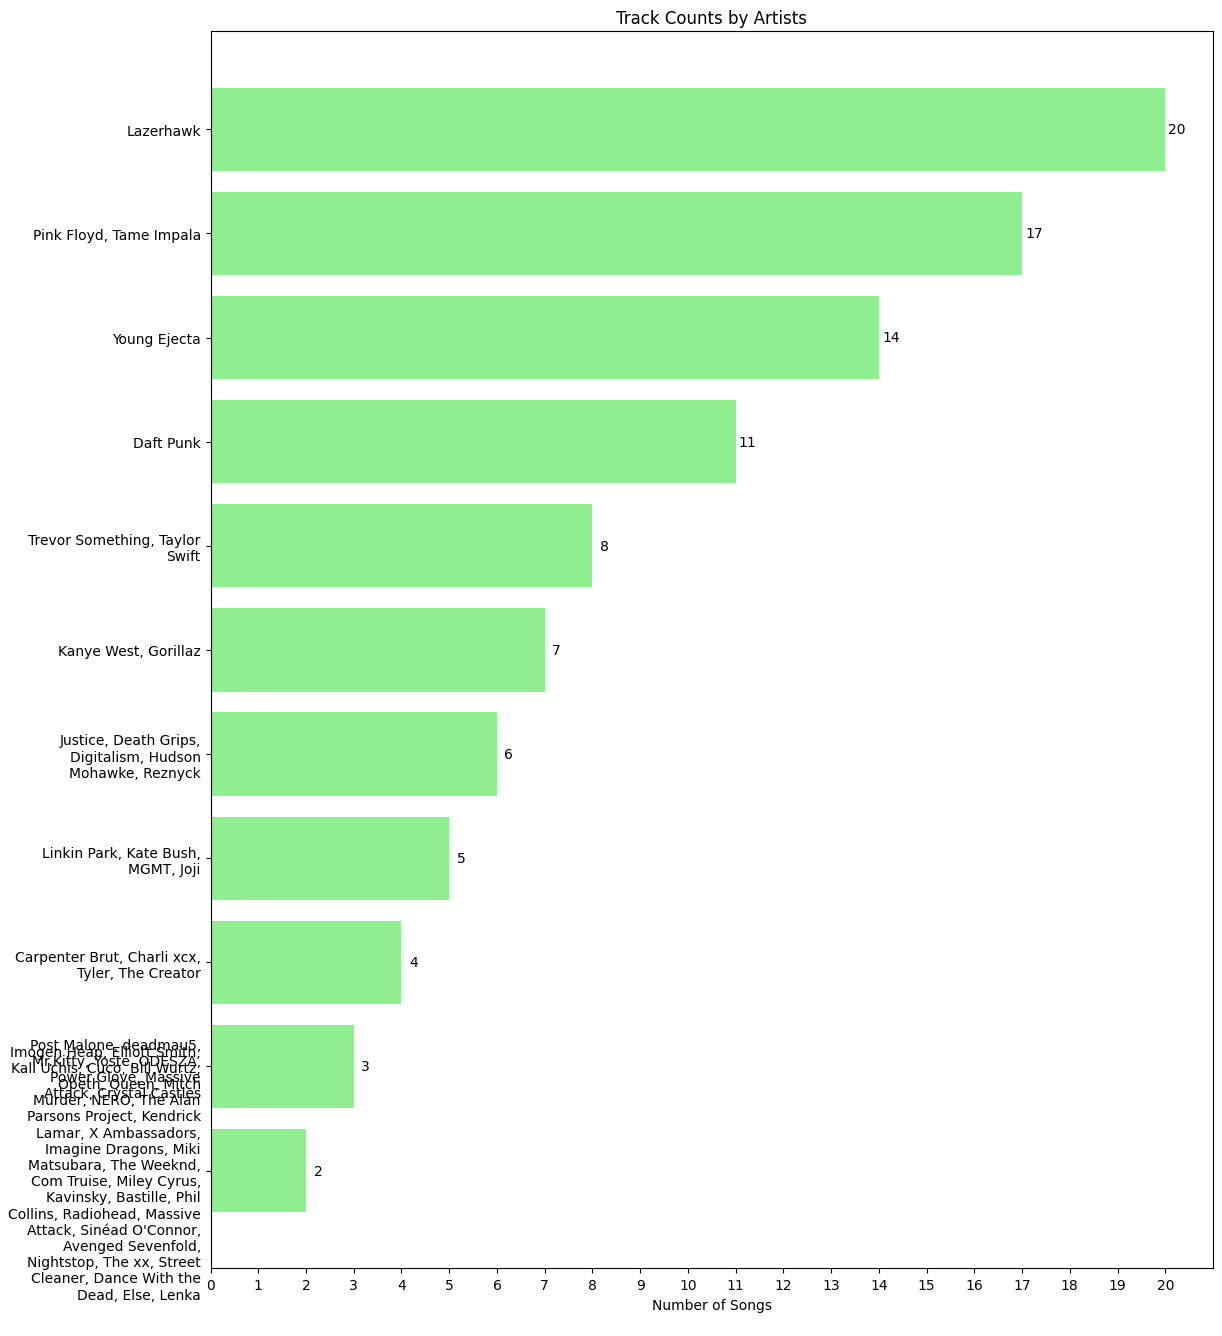

In [41]:
# Creating a bar chart to visualise all multiple-entrant artists

grouped_multi_artists = multi_song_artists.groupby(multi_song_artists).apply(lambda x: ', '.join(x.index))

plt.figure(figsize=(12, 14))
plt.barh(grouped_multi_artists, grouped_multi_artists.index, color='lightgreen')

plt.xlabel('Number of Songs')
plt.ylabel('Artists')
plt.title('Track Counts by Artists')

plt.yticks(rotation=0, ha='right', wrap=True)
plt.xticks(range(0, max(grouped_multi_artists.index) + 1, 1))
plt.tight_layout()

for index, value in enumerate(grouped_multi_artists.index):
    plt.text(value + 0.25, index, str(value), va='center', ha='center', fontsize=10)

plt.show()

#### One-year Dream Runs

Ever had a very ephemeral earworm? A song that you listened to a whole lot, but only for a short while? Or, songs that were very "of a particular time" for you? They frequently end up in the Top 10 for me each year, and then completely vanish from my Wrapped the next year. Here's some data analysis on them! 

In [42]:
# Getting the top 10 tracks of each year in a single dataframe

# For all years, create a mask for all rows with rank < 10 in any year
top_10s = pivot_df[pivot_df[years].apply(lambda x: x.between(1, 10)).any(axis=1)]

top_10s

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
1,Wicked Game,Chris Isaak,0101c1eef15d16de8f4a55dab2ee2625,3,0,0,0,0,2,78,62
26,Echoes,Pink Floyd,0e50b9e4c2e8a156b58d59e5084a8b7b,3,0,0,0,1,33,22,0
48,Die For You,Joji,1b977dd4331489684ae513eb17ec680d,1,0,0,0,0,0,0,2
52,Instant Crush (feat. Julian Casablancas),"Daft Punk, Julian Casablancas",1d7c4f5897130ba37a747c11b9dd1572,2,2,80,0,0,0,0,0
61,Horsepower,Justice,209192d24dc084bbef046c672164eec7,3,0,0,0,0,8,31,34
...,...,...,...,...,...,...,...,...,...,...,...
436,Ending,Ahoy,e5f56c4c94e188918b030ffae201f0e6,2,0,0,0,0,0,10,82
446,Mayonaka no Door / Stay With Me,Miki Matsubara,ec2a500c2bed21655252ea3d3db68db0,1,0,0,0,0,0,2,0
459,Roadgame,Kavinsky,f5356a60240117c785c41c350bb16ba5,2,0,0,98,9,0,0,0
469,Headlock,Imogen Heap,fa13f05f99ecbaebba7a6ad720b38d16,1,0,0,0,0,0,0,5


In [43]:
# Filtering all top 10s which vanished from the list the next year

dream_runs = pd.DataFrame()

def one_year_filter(row):
    for year in years[:-1]: # TODO: go by index in years, in case any year is skipped
        if ((row[year] < 10 and row[year] > 0) and row[year + 1] == 0): 
            return year
    return None

dream_runs = (top_10s.copy()
              .assign(dream_year=top_10s.apply(one_year_filter, axis=1))
              .dropna(subset=['dream_year'])
              .astype({'dream_year': int})
              .drop(columns=['song_id', 'list_appearances'])
              .sort_values(by='dream_year'))
dream_runs

,name,artists,2018,2019,2020,2021,2022,2023,2024,dream_year
215,Just Take Me Home,Maxthor,7,0,0,0,0,0,0,2018
255,Take Me Out,Franz Ferdinand,3,0,0,0,0,0,0,2018
129,OKRA,"Tyler, The Creator",0,1,0,0,59,0,0,2019
120,See You Again (feat. Kali Uchis),"Tyler, The Creator, Kali Uchis",0,3,0,0,0,0,0,2019
404,Dance Yrself Clean,LCD Soundsystem,31,9,0,0,89,0,0,2019
297,Take on Me,a-ha,0,0,3,0,0,0,0,2020
175,Old and Wise,The Alan Parsons Project,0,0,0,2,0,0,0,2021
81,Feels Like We Only Go Backwards,Tame Impala,0,0,0,8,0,0,0,2021
357,If,Pink Floyd,0,0,2,6,0,0,0,2021
301,I Want Your Love,Trevor Something,0,0,0,4,0,0,88,2021


##### Plot to visualise the Top 10 "dream run" tracks from each year recorded

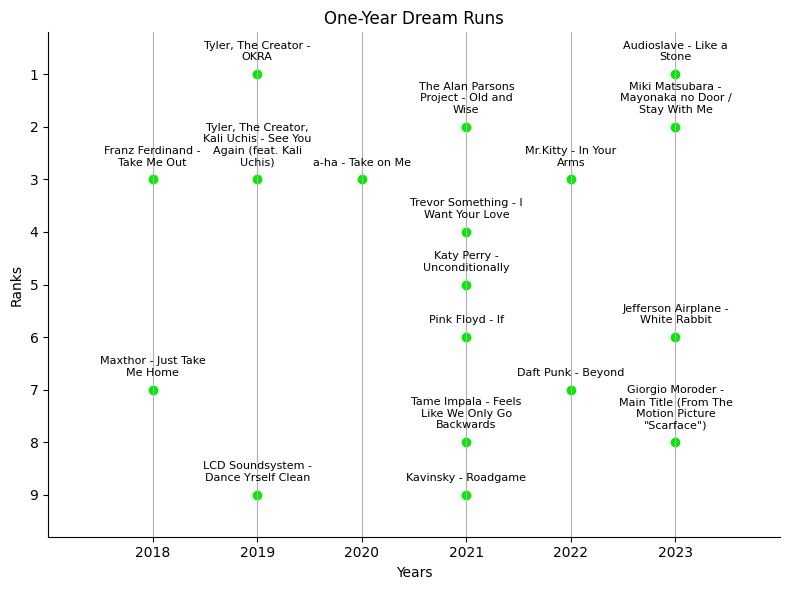

In [44]:
# scatter plot to visualise dream run tracks

scatter_dream_runs = dream_runs.copy()

scatter_dream_runs['pos'] = scatter_dream_runs.apply(lambda row: row[row['dream_year']], axis=1)
scatter_dream_runs['anno'] = scatter_dream_runs['artists'] + ' - ' + scatter_dream_runs['name']
scatter_dream_runs = scatter_dream_runs.drop(columns=years)

plt.figure(figsize=(8, 6))
plt.scatter(scatter_dream_runs['dream_year'], scatter_dream_runs['pos'], c='#00ed00')

for index, row in scatter_dream_runs.iterrows():
    wrap = textwrap.fill(row['anno'], width=20)
    plt.annotate(wrap, (row['dream_year'], row['pos']), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

plt.xlabel('Years')
plt.ylabel('Ranks')
plt.title('One-Year Dream Runs')

plt.yticks(range(1, 11, 1))
plt.xticks(range(min(scatter_dream_runs['dream_year']), max(scatter_dream_runs['dream_year']) + 1, 1))

plt.margins(x=0.2, y=0.1)
plt.grid(axis='x')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().invert_yaxis()

plt.tight_layout()

plt.show()

#### On The Up

Tracks that ended up higher in a list than the previous year's list on one occasion, or returned to the lists after being absent for a year or more.

In [45]:
# "recovering tracks - with >= 2 appearances, the ones that went up over a year in ranks, 
# or returned to the lists after being absent

two_df = pivot_df[pivot_df['list_appearances'] >= 2]
# two_df

# each row each year, if the next is larger than the previous, recovery, else not...?
recover_df = pd.DataFrame(columns=two_df.columns)
# print(years)

for index, row in two_df.iterrows():
    off_list = False
    for i in range(len(years) - 1):
        current_year = years[i]
        next_year = years[i + 1]

        curr_value = row[current_year]
        next_value = row[next_year]
        
        if curr_value != 0 and next_value == 0:
            off_list = True
        if (next_value < curr_value or off_list) and next_value != 0:
            recover_df = pd.concat([recover_df, row.to_frame().T], ignore_index=True)
            break

recover_df


,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
0,Wicked Game,Chris Isaak,0101c1eef15d16de8f4a55dab2ee2625,3,0,0,0,0,2,78,62
1,forever,Charli xcx,0570d6879c057508e100a637c4a8af23,3,0,0,0,14,35,0,94
2,Eclipse,Pink Floyd,071f981f35b74964b8c19457fe713da7,2,0,0,42,0,0,100,0
3,Die For You,"VALORANT, Grabbitz",0a0f30611f911c46a414d789ce78510f,2,0,0,0,0,19,0,86
4,Baba O'Riley,The Who,0c749fbe7ff542afdc1c76586609279b,3,0,59,86,0,76,0,0
...,...,...,...,...,...,...,...,...,...,...,...
66,snowfall,"Øneheart, reidenshi",e910c491eeacdb85d0bdb0b7a2569040,2,0,0,0,0,0,63,30
67,We're Finally Landing,Home,edb4f702f7d72c8a322ae41199b2eac0,3,0,0,0,0,46,97,49
68,9 to 5,Young Ejecta,f207124e45b2520d23e6f54161a15520,2,0,0,0,0,0,57,19
69,Roadgame,Kavinsky,f5356a60240117c785c41c350bb16ba5,2,0,0,98,9,0,0,0


In [46]:
# more with recover_df, 1. all "climbed" tracks and visualising the delta

recover_df

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
0,Wicked Game,Chris Isaak,0101c1eef15d16de8f4a55dab2ee2625,3,0,0,0,0,2,78,62
1,forever,Charli xcx,0570d6879c057508e100a637c4a8af23,3,0,0,0,14,35,0,94
2,Eclipse,Pink Floyd,071f981f35b74964b8c19457fe713da7,2,0,0,42,0,0,100,0
3,Die For You,"VALORANT, Grabbitz",0a0f30611f911c46a414d789ce78510f,2,0,0,0,0,19,0,86
4,Baba O'Riley,The Who,0c749fbe7ff542afdc1c76586609279b,3,0,59,86,0,76,0,0
...,...,...,...,...,...,...,...,...,...,...,...
66,snowfall,"Øneheart, reidenshi",e910c491eeacdb85d0bdb0b7a2569040,2,0,0,0,0,0,63,30
67,We're Finally Landing,Home,edb4f702f7d72c8a322ae41199b2eac0,3,0,0,0,0,46,97,49
68,9 to 5,Young Ejecta,f207124e45b2520d23e6f54161a15520,2,0,0,0,0,0,57,19
69,Roadgame,Kavinsky,f5356a60240117c785c41c350bb16ba5,2,0,0,98,9,0,0,0


In [47]:
# viz. for recovering tracks and by how much did each go up (exclude off_list tracks)
# maybe expand on recover_df, add params ('off_list/climbed', 'upward delta (if climbed)')

#### First to Last Time

A closer look at your first Wrapped playlist. What tracks didn't return to the playlists ever again, which ones did, and which ones still found a place in your latest Wrapped playlist?

In [48]:
# How are the tracks from your first Wrapped doing in subsequent lists (if they made it in any lists afterwards,
# and the ones that didn't, where were they ranked?)

df_first = pivot_df[pivot_df[years[0]] > 0]
first_none_mask = df_first[years[1:]].eq(0).all(axis=1)

df_first_none = df_first[first_none_mask]
df_first_not_none = df_first[~first_none_mask]

print(f"Songs from {years[0]}'s Wrapped that were in subsequent lists = {df_first_not_none.shape[0]}")
print(f"Songs from {years[0]}'s Wrapped that were not in subsequent lists = {df_first_none.shape[0]}")

# TODO: (new) per-playlist attrition (needs more determination, what about previous lists)
# Songs present in the last Wrapped 


# df_first_not_none
# df_first.sort_values(by=years[0])

Songs from 2018's Wrapped that were in subsequent lists = 32
Songs from 2018's Wrapped that were not in subsequent lists = 68


In [49]:
# Songs only appearing in the following list

df_only_next = df_first_not_none[df_first_not_none[years[2:]].eq(0).all(axis=1)]

df_only_next['delta'] = df_only_next.apply(lambda row: row[years[1]] - row[years[0]], axis=1)
df_only_next[['name', 'artists', years[0], years[1], 'delta']].sort_values('delta')

,name,artists,2018,2019,delta
252,11th Dimension,Julian Casablancas,89,34,-55
293,Contact,Logic,72,36,-36
182,"End of Line - From ""TRON: Legacy""/Score",Daft Punk,68,33,-35
144,Memory,Com Truise,60,26,-34
149,Roller Mobster,Carpenter Brut,48,28,-20
370,Hardware Passion,Waveshaper,39,32,-7
464,YEAH RIGHT,Joji,25,27,2
382,Watch Dogs Theme,Hudson Mohawke,8,12,4
300,milky skittles,Manatee Commune,83,90,7
396,Veridis Quo,Daft Punk,35,64,29


In [50]:
# Songs from the first Wrapped present in the last Wrapped 

df_first_not_none[df_first_not_none[years[-1]] > 0]

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
87,On Melancholy Hill,Gorillaz,2f98ce118dc3ca90fce51375e97af503,5,4,56,0,96,0,34,91
95,SLOW DANCING IN THE DARK,Joji,340493b65aed689763cc3ddf03bb028d,5,1,38,46,0,0,81,48
296,Giorgio by Moroder,Daft Punk,9eeab4027cca0a827643417e70d0b54a,4,46,25,0,97,0,0,78


## under development sections:

In [51]:
# DEV

top_10s[(top_10s[2019] > 0) & (top_10s[2019] <= 10)].sort_values(by=2019)

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
129,OKRA,"Tyler, The Creator",4557868dec4b6432e549829a6668dbca,2,0,1,0,0,59,0,0
191,Pogo,Digitalism,6344161bf601981e314e1e81d8c061cc,3,0,2,47,76,0,0,0
120,See You Again (feat. Kali Uchis),"Tyler, The Creator, Kali Uchis",413ce21e6696f5c75e5e8ca36c17a929,1,0,3,0,0,0,0,0
428,Star Hustler,Lazerhawk,e295b0e06667f7c55c2cded67768eb27,6,0,4,31,52,60,84,79
298,Nacht,Nina Müller,a077ea899caae692c59d2ea63a7ce735,3,0,5,39,86,0,0,0
407,Ni**as In Paris,"JAY-Z, Kanye West",d6d454fb086ef39aaa83490b248e45cb,2,0,6,71,0,0,0,0
381,Amethyst,Hudson Mohawke,ca682e1a03ca70bd6a1a7fc058774723,2,0,7,63,0,0,0,0
89,Runaway,"Kanye West, Pusha T",32000bd8a39dc5a0b7b3204850a6f3fb,3,0,8,44,0,0,0,35
404,Dance Yrself Clean,LCD Soundsystem,d5e3f8bd2cb930ff22267ea6a51547a7,3,31,9,0,0,89,0,0
348,Everlong,Foo Fighters,bc048c624ced66e3924d8a4c03c11c30,1,0,10,0,0,0,0,0


In [52]:
top_10s[top_10s[years].eq(3).any(axis=1)]

# df_first_not_none[df_first_not_none[years[2:]].eq(0).all(axis=1)]

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
118,Eleanor Lye,Young Ejecta,4121f83bb42ff8426ef4d4dfe26519ba,3,0,0,0,0,54,5,3
120,See You Again (feat. Kali Uchis),"Tyler, The Creator, Kali Uchis",413ce21e6696f5c75e5e8ca36c17a929,1,0,3,0,0,0,0,0
255,Take Me Out,Franz Ferdinand,848405e65cf2e1eca6462c2f352836f2,1,3,0,0,0,0,0,0
266,In Your Arms,Mr.Kitty,8ac96039517e4ae1ac136432bbe929d9,1,0,0,0,0,3,0,0
273,After Dark,Mr.Kitty,8f078a2d54bbcbee6b132d0f05252881,4,0,0,4,3,17,93,0
292,Build a Fire,Young Ejecta,9cf983deed7ef257a7157414ab0c8226,2,0,0,0,0,0,3,36
297,Take on Me,a-ha,a05aec571875b39af1286dc38f4addd5,1,0,0,3,0,0,0,0


In [53]:
year_to_refer = 2022
artist_to_refer = 'Wolfgang Amadeus Mozart'
pivot_df[(pivot_df['artists'] == artist_to_refer) & (pivot_df[year_to_refer] > 0)][['name', 'artists', year_to_refer]]

,name,artists,2022


In [54]:
pivot_df[(pivot_df['artists'] == "Charli XCX")] #[['name', 'artists']]

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024


In [55]:
pivot_df[pivot_df['name'] == 'pink diamond']

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
50,pink diamond,Charli xcx,1c6edc2812de627b4da36bbc9812c270,3,0,0,48,53,95,0,0


In [56]:
# present in 3 or more lists

three_df = pivot_df[pivot_df['list_appearances'] >= 3]

three_df

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
1,Wicked Game,Chris Isaak,0101c1eef15d16de8f4a55dab2ee2625,3,0,0,0,0,2,78,62
14,forever,Charli xcx,0570d6879c057508e100a637c4a8af23,3,0,0,0,14,35,0,94
15,Taking Control,Moskva-Kassiopeya,0605630d6a20e130c30218658816847b,3,0,22,64,92,0,0,0
23,Baba O'Riley,The Who,0c749fbe7ff542afdc1c76586609279b,3,0,59,86,0,76,0,0
26,Echoes,Pink Floyd,0e50b9e4c2e8a156b58d59e5084a8b7b,3,0,0,0,1,33,22,0
50,pink diamond,Charli xcx,1c6edc2812de627b4da36bbc9812c270,3,0,0,48,53,95,0,0
61,Horsepower,Justice,209192d24dc084bbef046c672164eec7,3,0,0,0,0,8,31,34
87,On Melancholy Hill,Gorillaz,2f98ce118dc3ca90fce51375e97af503,5,4,56,0,96,0,34,91
89,Runaway,"Kanye West, Pusha T",32000bd8a39dc5a0b7b3204850a6f3fb,3,0,8,44,0,0,0,35
93,Love/Paranoia,Tame Impala,32dc4e515f942b56c82194bb4d18fc64,3,0,0,0,0,6,23,97


In [57]:
# present in 2 or more lists

two_df = pivot_df[pivot_df['list_appearances'] >= 2]

two_df

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
1,Wicked Game,Chris Isaak,0101c1eef15d16de8f4a55dab2ee2625,3,0,0,0,0,2,78,62
5,Atlas Air,Massive Attack,0242534c590ff346860fc186beb94044,2,0,0,0,0,0,72,84
14,forever,Charli xcx,0570d6879c057508e100a637c4a8af23,3,0,0,0,14,35,0,94
15,Taking Control,Moskva-Kassiopeya,0605630d6a20e130c30218658816847b,3,0,22,64,92,0,0,0
16,Eclipse,Pink Floyd,071f981f35b74964b8c19457fe713da7,2,0,0,42,0,0,100,0
...,...,...,...,...,...,...,...,...,...,...,...
458,Voyager,Daft Punk,f3a1b3eb4724e6a34de6997760cab7ad,2,13,49,0,0,0,0,0
459,Roadgame,Kavinsky,f5356a60240117c785c41c350bb16ba5,2,0,0,98,9,0,0,0
464,YEAH RIGHT,Joji,f88865346db01939c05a9e5343792bbe,2,25,27,0,0,0,0,0
471,Everything Is Embarrassing,Sky Ferreira,fb5ba6302178b83b2af9d61e64a43ee7,3,0,0,0,0,13,39,66


In [58]:
# present in 4 or more lists

four_df = pivot_df[pivot_df['list_appearances'] >= 4]

four_df

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
87,On Melancholy Hill,Gorillaz,2f98ce118dc3ca90fce51375e97af503,5,4,56,0,96,0,34,91
95,SLOW DANCING IN THE DARK,Joji,340493b65aed689763cc3ddf03bb028d,5,1,38,46,0,0,81,48
206,Flower Dance,DJ Okawari,6a36d5a232998b26eecaf3c7ad4919c6,4,0,0,0,48,14,73,44
268,Overdrive,Lazerhawk,8cf6494b186a5d405277104940becce2,4,0,0,1,30,64,0,8
273,After Dark,Mr.Kitty,8f078a2d54bbcbee6b132d0f05252881,4,0,0,4,3,17,93,0
276,Little Dark Age,MGMT,90d8034c79eca6b05da385f300922833,4,0,0,5,28,57,0,93
296,Giorgio by Moroder,Daft Punk,9eeab4027cca0a827643417e70d0b54a,4,46,25,0,97,0,0,78
327,Intro,The xx,b0f6984c05042336617fcd2073c6c54c,6,0,16,23,67,96,98,40
380,Unspecial effects,deadmau5,c9ccaa759a603b4b6a4d49a70400a862,4,23,0,0,82,48,99,0
428,Star Hustler,Lazerhawk,e295b0e06667f7c55c2cded67768eb27,6,0,4,31,52,60,84,79


In [59]:
# one timers

one_df = pivot_df[pivot_df['list_appearances'] == 1]

one_df

,name,artists,song_id,list_appearances,2018,2019,2020,2021,2022,2023,2024
0,Hosanna,"A.R. Rahman, Vijay Prakash, Suzanne D'Mello, B...",005698f0a285de5d1840ba421dfb46bf,1,0,0,0,0,0,52,0
2,Cyanide Sisters,Com Truise,01187eabbb2a880d260981f09a17e2ac,1,0,54,0,0,0,0,0
3,Moonbound,Anzo,01713517d52d7c48b343ec249d764d93,1,44,0,0,0,0,0,0
4,Rabbit Run,Eminem,01984bb77124a4ed14ddd8aef2ae31fa,1,38,0,0,0,0,0,0
6,Thé à la menthe (The Lazer Dance Version) [Ins...,La Caution,02b9fdcf63870bb4f885df2f3d2c5552,1,0,0,0,0,0,60,0
...,...,...,...,...,...,...,...,...,...,...,...
470,Unstoppable,Sia,fae6ff6bceedf4924842e20bfb42b2b8,1,0,0,0,0,11,0,0
472,Contact,Foreign Beggars,fbbf29bae7fd7bdfa0f9f6952edc7643,1,0,0,0,0,0,77,0
473,Blood Dragon Theme,Power Glove,fc47fb677fe2f7622bc81cc874669957,1,49,0,0,0,0,0,0
474,I Knew You Were Trouble.,Taylor Swift,fc4e90153d6a332038d774e13a766f09,1,0,0,59,0,0,0,0


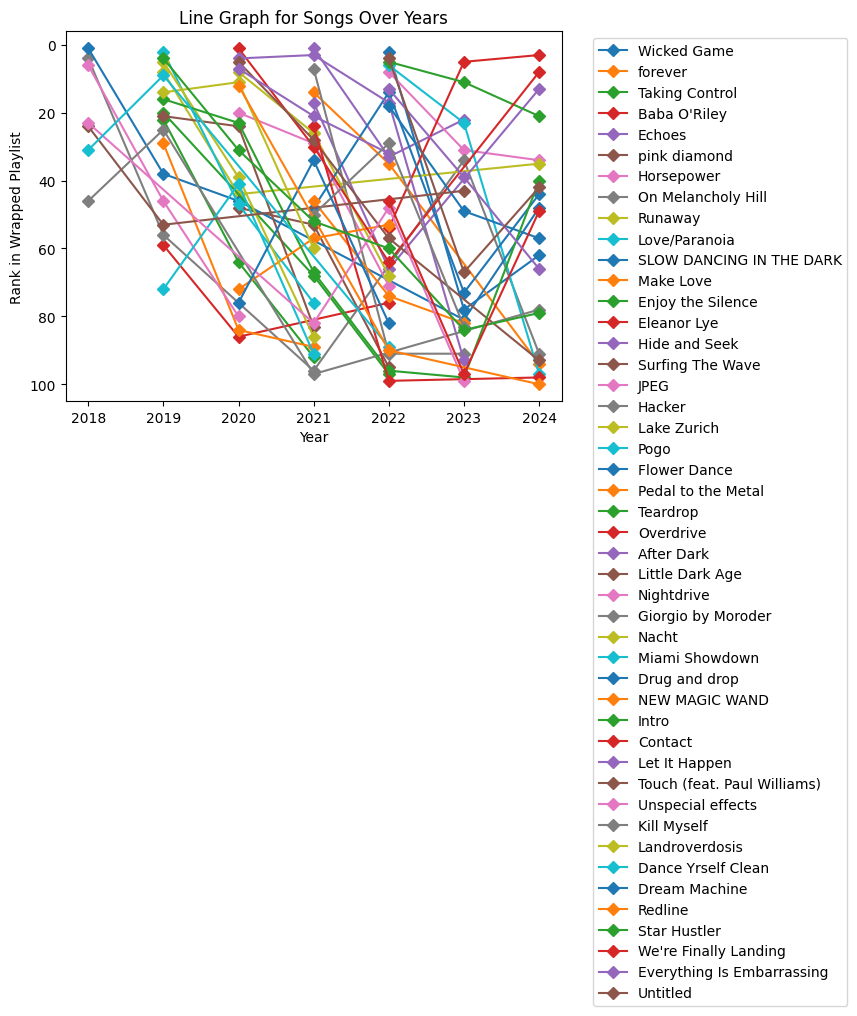

In [60]:
# generic line graph maker - for reference

sample_df = three_df
years = sample_df.columns[4:]

for index, row in sample_df.iterrows():
    non_zero_values = [(year, value) for year, value in zip(years, row[4:]) if value != 0]
    if non_zero_values:
        years_non_zero, values_non_zero = zip(*non_zero_values)
        plt.plot(years_non_zero, values_non_zero, marker='D', label=row['name'])
        
# Adding title and labels
# plt.figure(figsize=(15, 15))

plt.title('Line Graph for Songs Over Years')
plt.xlabel('Year')
plt.ylabel('Rank in Wrapped Playlist')

plt.xticks(range(int(min(years)), int(max(years)) + 1))

# Adding a legend to identify each line
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()

# Display the graph
plt.show()

In [61]:
# some sort of statistical metric to track consistency of the track in the rankings where it's present in >3
# + most successful tracks, making it to the top of these lists and such - ARSI (check GPT)

In [62]:
# one list to another: which adjacent have the greatest overlap?

In [63]:
# artists' best years, most common apperances, ups-and-downs over the years 
# an illustration: MGMT - 2021 super dense, fell off after

In [64]:
# 3 or more appearances, graphing them